# MLP on MINST Dataset

In this notebook, we will be making a multi-layer Perceptron to classify the MNIST dataset. We will be using softmax as our criteria.

In [1]:
include("../src/NN.jl")
using NN
using PyPlot

# Data Generation & Datasplit

We will be splitting the data into three sets: training, validation and testing sets. Corresponding percentage will be 80%, 10% and 10%.

In [2]:
include("../util/datasets.jl")
X,Y = mnistData(ttl=55000) # 0-1
println("X statistics: $(mean(X)) $(minimum(X)) $(maximum(X))")

Y = round(Int, Y)
train_set, test_set, validation_set = datasplit(X,Y;ratio=10./11.)
trX, trY = train_set[1], train_set[2]
valX, valY = validation_set[1], validation_set[2]
teX, teY = test_set[1], test_set[2]

trX  = permutedims(reshape(trX,  (size(trX,1),  1, 28, 28)), [3,4,2,1])
valX = permutedims(reshape(valX, (size(valX,1), 1, 28, 28)), [3,4,2,1])
teX  = permutedims(reshape(teX,  (size(teX,1),  1, 28, 28)), [3,4,2,1])

println("TrainSet: $(size(trX)) $(size(trY))")
println("ValSet  : $(size(valX)) $(size(valY))")
println("TestSet : $(size(teX)) $(size(teY))")


X statistics: 0.13008379069312384 0.0 0.99609375
TrainSet: (28,28,1,50000) (50000,1)
ValSet  : (28,28,1,2499) (2499,1)
TestSet : (28,28,1,2501) (2501,1)


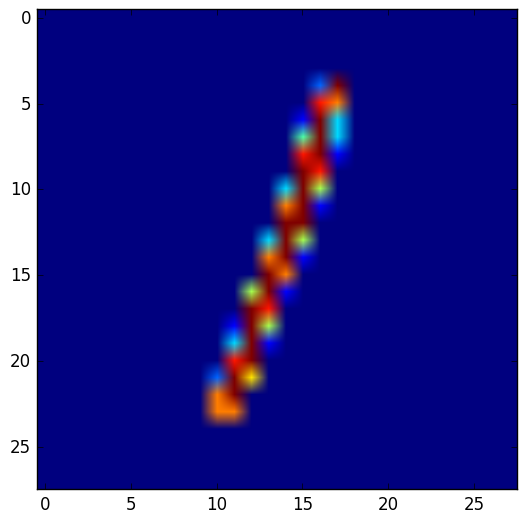

PyObject <matplotlib.image.AxesImage object at 0x33ddb4350>

In [3]:
i = convert(Int, ceil(rand() * size(trY)[1]))
x =reshape(trX[:,:,:,i], 28,28) ./ 256
imshow(x)

# Network Structure

In [4]:
function build_cnn(batch_size = 500)
    layers = Layer[
        InputLayer((28,28,1,batch_size)),
        CaffeConv(32,(5,5)),
        ReLu(),
        MaxPoolingLayer((2,2)),

        CaffeConv(32,(5,5)),
        ReLu(),
        MaxPoolingLayer((2,2)),

        Flatten(),

        DenseLayer(256),
        ReLu(),

        DropoutLayer(0.5),
        DenseLayer(10)
    ]

    criteria = SoftMaxCrossEntropyLoss()
    net = SequentialNet(layers, criteria)
    return net
end

build_cnn (generic function with 2 methods)

In [5]:
function get_corr(pred, answ)
    return length(filter(e -> abs(e) < 1e-5, pred-answ))
end

function Adam(net::SequentialNet, train_set, validation_set;
    batch_size::Int64 = 16, ttl_epo::Int64 = 10, lrSchedule = 0.01,
    beta_1::Float64 = 0.9, beta_2::Float64 = 0.999, verbose=0)
    X, Y = train_set
    valX, valY = validation_set
    local N = size(Y)[1]
    local batch=0
    local epo_losses = []
    local epo_accus = []

    local val_losses = []
    local val_accu   = []

    m_t, v_t = [], []
    for i = 1:length(net.layers)
        layer = net.layers[i]
        param = getParam(layer)
        if param == nothing
            push!(m_t, nothing)
            push!(v_t, nothing)
        else
            c_1, c_2 = [], []
            for j = 1:length(param)
                push!(c_1, zeros(size(param[j])))
                push!(c_2, zeros(size(param[j])))
            end
            push!(m_t, c_1)
            push!(v_t, c_2)
        end;
    end;

    iter = 1 # number of iterations
    all_losses = []
    for epo = 1:ttl_epo
        epo_time_used = @elapsed begin
            local num_batch = ceil(N/batch_size)
            epo_cor = 0
            for bid = 0:(num_batch-1)
                time_used = @elapsed begin
                    batch += 1
                    local sidx::Int = convert(Int64, bid*batch_size+1)
                    local eidx::Int = convert(Int64, min(N, (bid+1)*batch_size))
                    local batch_X = X[:,:,:,sidx:eidx]
                    local batch_Y = Y[sidx:eidx,:]
                    loss, pred = forward(net, batch_X, batch_Y)
                    backward(net, batch_Y)

                    for i = 1:length(net.layers)
                        layer = net.layers[i]
                        param = getParam(layer)
                        if param == nothing
                            continue # not a learnable layer
                        end

                        grad  = getGradient(layer)
                        for j = 1:length(param)
                            m = m_t[i][j]
                            v = v_t[i][j]
                            p = param[j]
                            g = grad[j]
                            @assert size(m) == size(p) && size(m) == size(g) && size(m) == size(v)

                            # Moving average to approximate gradient with velocity
                            m = m * beta_1 + g    * (1 - beta_1)
                            v = v * beta_2 + g.^2 * (1 - beta_2)

                            # Compute the counter biased version of [m] and [v]
                            m_hat = m / (1. - beta_1^iter)
                            v_hat = v / (1. - beta_2^iter)

                            # Update gradients
                            p = p - lrSchedule(epo) * m_hat ./ (sqrt(v_hat) + 1e-4)

                            # store the things back
                            param[j] = p
                            m_t[i][j] = m
                            v_t[i][j] = v

                        end
                        setParam!(layer, param)
                    end
                    iter += 1

                    append!(all_losses, mean(loss))
                    epo_cor  += get_corr(pred, batch_Y)
                    local acc = get_corr(pred, batch_Y) / batch_size
                end
#                 println("[$(bid)/$(num_batch)]($(time_used)s) Loss is: $(mean(loss))\tAccuracy:$(acc)")
            end

            v_size = size(valX)[1]
            v_loss, v_accu = [],[]
            for i = 1:batch_size:v_size
                batch_X = valX[:,:,:,i:i+batch_size-1]
                batch_Y = valY[i:i+batch_size-1,:]
                curr_v_loss, curr_v_pred = forward(net, batch_X, batch_Y;deterministics=true)
                curr_v_accu = get_corr(curr_v_pred, batch_Y) / batch_size
                append!(v_loss, curr_v_loss)
                append!(v_accu, curr_v_accu)
            end
            append!(val_losses, mean(v_loss))
            append!(val_accu,   mean(v_accu))
        end
        println("Epo $(epo) [$(epo_time_used)s] has loss :$(mean(v_loss))\t\taccuracy : $(mean(v_accu))")
    end
    return epo_losses,epo_accus, val_losses, val_accu,all_losses
end


Adam (generic function with 1 method)

Epo 1 [189.514426118s] has loss :0.3246857591617487		accuracy : 0.942
Epo 2 [177.728600636s] has loss :0.22296585762111973		accuracy : 0.952
Epo 3 [206.230602024s] has loss :0.17348992857396225		accuracy : 0.956
Epo 4 [199.632999051s] has loss :0.16480160794414928		accuracy : 0.96
Epo 5 [173.698280323s] has loss :0.13807991180749174		accuracy : 0.966
Epo 6 [175.638551795s] has loss :0.12690225485402193		accuracy : 0.968
Epo 7 [195.07881178s] has loss :0.11717801542279797		accuracy : 0.976
Epo 8 [202.196578687s] has loss :0.11634406399853567		accuracy : 0.976
Epo 9 [208.825284014s] has loss :0.09941197960473737		accuracy : 0.974


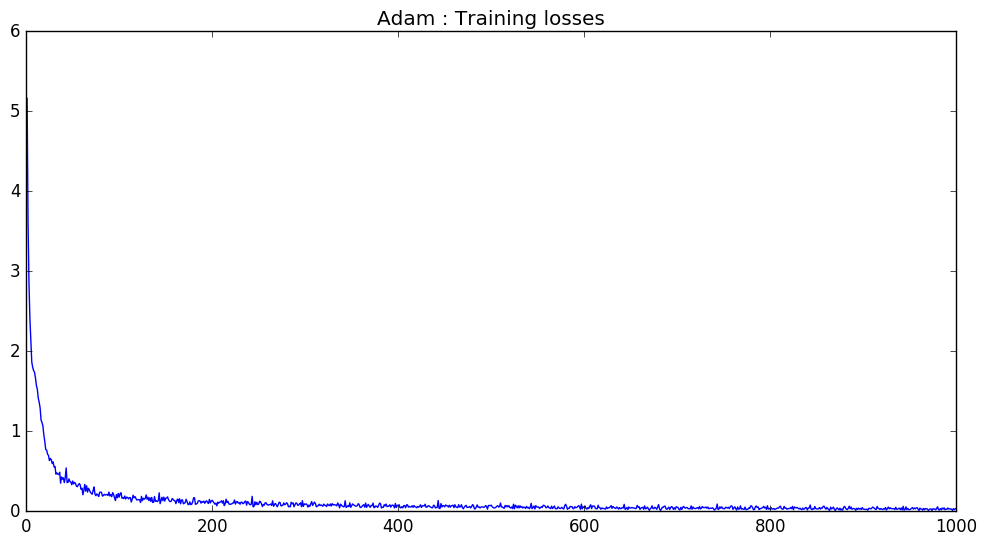

Epo 10 [189.969177826s] has loss :0.09209567607631507		accuracy : 0.974


PyObject <matplotlib.text.Text object at 0x316c04a90>

In [6]:
batch_size = 500;
net = build_cnn()
epo_losses, epo_accu, val_losses, val_accu, all_losses = Adam(
    net, (trX, trY), (valX, valY);
    ttl_epo = 10, batch_size = batch_size,
    lrSchedule = x -> 0.001, verbose=1
)

figure(figsize=(12,6))
plot(1:length(all_losses), all_losses)
title("Adam : Training losses")


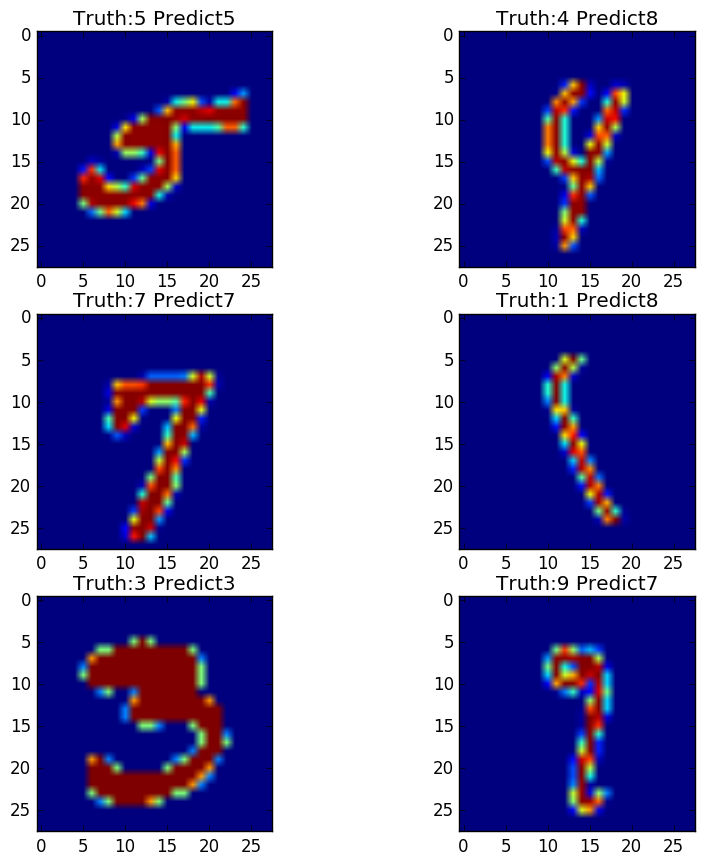

Testing Accuracy:0.9904038384646141


In [9]:
train_loss, pred = forward(net, teX, teY; deterministics = true)
N = size(teX)[4]
corr = length(filter(i-> abs(pred[i] - teY[i]) <  1e-5, 1:N))
right_idx = filter(i-> abs(pred[i] - teY[i]) <  1e-5, 1:N)[1:3]
wrong_idx = filter(i-> abs(pred[i] - teY[i]) >= 1e-5, 1:N)[1:3]

println("Testing Accuracy:$(corr/N)")

figure(figsize=(10,10))
subplot(321)
imshow(reshape(teX[:,:,:,right_idx[1]], 28,28))
title("Truth:$(teY[right_idx[1]]) Predict$(pred[right_idx[1]])")

subplot(322)
imshow(reshape(teX[:,:,:,wrong_idx[1]], 28,28))
title("Truth:$(teY[wrong_idx[1]]) Predict$(pred[wrong_idx[1]])")

subplot(323)
imshow(reshape(teX[:,:,:,right_idx[2]], 28,28))
title("Truth:$(teY[right_idx[2]]) Predict$(pred[right_idx[2]])")

subplot(324)
imshow(reshape(teX[:,:,:,wrong_idx[2]], 28,28))
title("Truth:$(teY[wrong_idx[2]]) Predict$(pred[wrong_idx[2]])")

subplot(325)
imshow(reshape(teX[:,:,:,right_idx[3]], 28,28))
title("Truth:$(teY[right_idx[3]]) Predict$(pred[right_idx[3]])")

subplot(326)
imshow(reshape(teX[:,:,:,wrong_idx[3]], 28,28))
title("Truth:$(teY[wrong_idx[3]]) Predict$(pred[wrong_idx[3]])")
show()

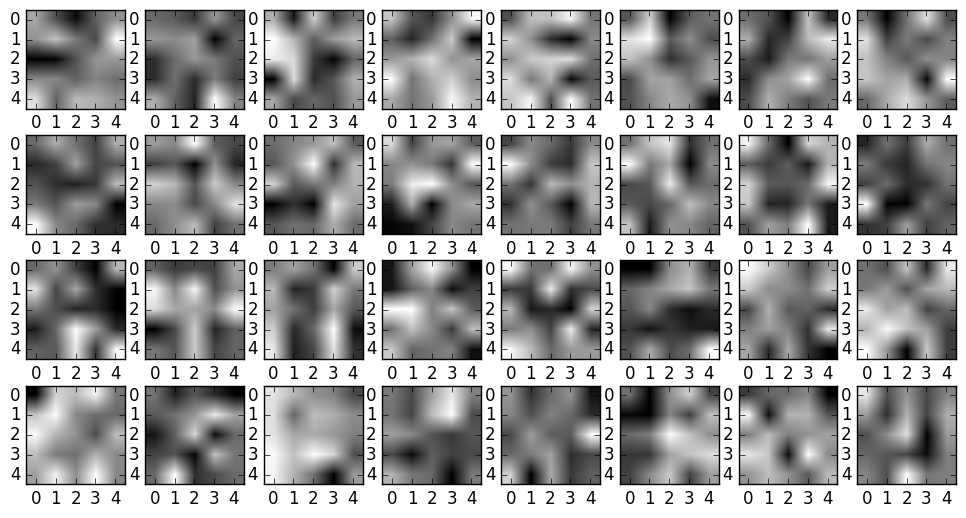

Kernel size:(5,5,1,32)


In [22]:
# Visualize the first layer filters
l = net.layers[2]
kernel = l.kern
println("Kernel size:$(size(kernel))");
figure(figsize=(12,6))
for f = 1:32
    subplot(4,8,f)
    k_img = kernel[:,:,:,f]
    imshow(reshape(k_img,5,5),cmap="gray")
end
savefig("first_layer_convfeatures.png")
show()